This is a study of workflows used in patrolling, for me to learn about the job of patrolling, the tools of the trade and how they are used.

## Prerequisites
You'll need Wikimedia analytics server access to run the Hive queries.  I can't post the data publicly without a review, so it's not included in this draft.

## API logs

Wikimedia keeps an archive of recently executed API commands, for a short time window.  These might have some signatures showing how patrollers are working.

Generate a TSV of API actions during a time window:

```sql
SELECT
  userAgent, wiki, params
FROM
  wmf_raw.ApiAction
WHERE year = 2018
  AND month = 6
  AND day = 20
  AND hadError = false
  AND
    (params['action'] = 'patrol')
;
```

    beeline -f api_patrolling.sql > patrolling_WINDOW.tsv

As you can see, this information is sensitive in its current form, so I won't upload it to source control:

```
useragent            wiki    params
Mozilla/[redacted]   frwiki  {"formatversion":"2","format":"json","action":"patrol","rcid":"148019620","token":"[redacted]"}
Mozilla/[redacted]   enwiki  {"formatversion":"2","format":"json","action":"patrol","rcid":"1064204306","token":"[redacted]"}
```

We'll read regexes and rules from a configuration file, and save transformed api log data to several streams:
* User agents, coerced to a small number of mid-level families.
* Whether the patrolling action is on a revision or a recent change.
* Any change tags that are set.


In [37]:
from collections import Counter
import csv
import json
import re
import yaml

with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [2]:
ua_family_log = []
target_type_log = []
tags_log = []
with open("patrolling_hour.tsv", "r") as f:
    api_actions = csv.DictReader(f, dialect='excel-tab')

    for line in api_actions:
        if line["params"] is not None:
            line["params"] = json.loads(line["params"])
        else:
            line["params"] = {}

        no_hits = True
        
        for rule in config["api_log"]["rules"]:
            hit = False
            
            if "ua_re" in rule:
                if re.search(rule["ua_re"], line["useragent"]):
                    hit = True
            
            if hit:
                action = rule["action"]
                no_hits = False
                if "ua_family" in action:
                    ua_family_log.append(action["ua_family"])
        
        if no_hits:
            print(line)
    
        if "revid" in line["params"]:
            target_type_log.append("revision")
        elif "rcid" in line["params"]:
            target_type_log.append("recent change")
        
        if "tags" in line["params"]:
            tags_log.append(line["params"]["tags"])

### User agent families

In [3]:
counts = Counter(ua_family_log).most_common()

counts

[('browser', 11064),
 ('bot-patrol', 1111),
 ('bot-127', 186),
 ('tool-Twinkle', 80),
 ('bot-Dungodung', 30),
 ('tool-morebits', 5),
 ('bot-wm-antivandal-daemon', 5),
 ('bot-mooc', 2)]

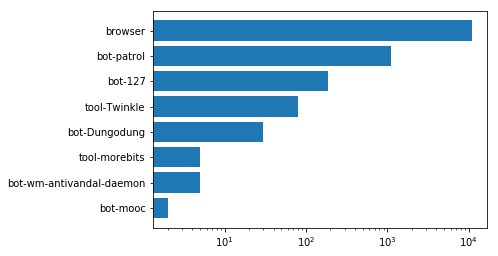

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
    log=True
)
plt.show()

### Patrolling target

In [5]:
counts = Counter(target_type_log).most_common()

counts

[('recent change', 10469), ('revision', 1929)]

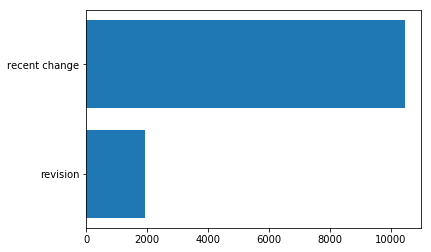

In [6]:
pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()

### Change tags

In [7]:
counts = Counter(tags_log).most_common()

counts

[]

Nobody uses the `tags` parameter!  This is worth filing a bug to either remove it from the API, or publicize its existence.

## Web request log

Now, let's look at the raw requests for more clues.

```sql
SELECT
  uri_query, uri_host, referer, user_agent, referer_class
FROM
  wmf.webrequest
WHERE year = 2018
  AND month = 6
  AND day = 20
  AND agent_type = 'user'
  AND
    parse_url(concat('http://foo/', uri_query), 'QUERY', 'action') = 'patrol'
;
```

Dice it up.

In [8]:
with open("patrolling_requests.tsv", "r") as f:
    requests = csv.DictReader(f, dialect='excel-tab')

    referer_log = []
    for line in requests:
        if line["referer"] is not None:
            known_referer = False
            for rule in config["web_log"]["rules"]:
                if re.search(rule["referer_re"], line["referer"]):
                    referer_log.append(rule["action"]["referer"])
                    known_referer = True
                
            if not known_referer:
                print(line["referer"])

### Referrers

In [9]:
counts = Counter(referer_log).most_common()

counts

[('Contributions', 164),
 ('RecentChanges', 104),
 ('LiveRC', 69),
 ('Watchlist', 11),
 ('[garbage]', 2)]

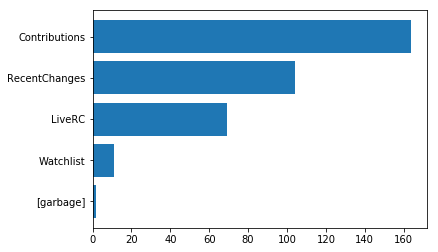

In [10]:
pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()

Oops.  It turns out these might not be valid patrolling requests at all.  They all include `assert=user` and have browser user agent.  In fact, we're only interested in POST requests, which don't expose API parameters to the web log.

## Engagement context

What exactly are patrollers doing when we receive actions directly from the browser?  They could be clicking the native MediaWiki "Mark as patrolled" button, or using assistive JS gadgets, it doesn't seem to be possible to distinguish from an analysis of the POST request alone.

Therefore, we'll try to survey gadget usage by joining the API and webrequest tables.

```sql
use wmf;
set mapred.job.queue.name=nice;

drop view awight_patroller_actions;
create view awight_patroller_actions as
select
  userAgent, ip
from
  wmf_raw.ApiAction
where year = 2018
  and month = 6
  and day = 23
  and hour = 0
  and hadError = false
  and
    (params['action'] = 'patrol')
group by
  -- Proxy for unique user
  ip, userAgent
;

drop view awight_patroller_context;
create view awight_patroller_context as
select
  dt, uri_host, uri_path, uri_query, ip, user_agent, http_method
from
  wmf.webrequest
where year = 2018
  and month = 6
  and day = 23
  and hour = 0
;

select
  context.*
from
  awight_patroller_context as context
join awight_patroller_actions as actions
    on
        actions.ip = context.ip
        and actions.userAgent = context.user_agent;
```

In [39]:
from operator import itemgetter
import itertools
import urllib.parse

# TODO: need to group by actor before iterating lines.

with open("patrol_context.tsv", "r") as f:
    requests = list(csv.DictReader(f, dialect='excel-tab'))

# Secondary sort on datetime
requests = sorted(requests, key=itemgetter("context.dt"))
# Primary sort on user
requests = sorted(requests, key=itemgetter("context.ip", "context.user_agent"))

# Group by user
grouped_requests = itertools.groupby(requests, key=itemgetter("context.ip", "context.user_agent"))
user_timelines = []
user_gadgets = []

for _, user_requests in grouped_requests:
    query_type_log = []
    gadget_log = []
    
    for line in user_requests:
        query_type = None

        # Build abstract engagement timeline by applying rules to the web request.
        for rule in config["gadgets"]["rules"]:
            hit_rule = False
            if "query_re" in rule and re.search(rule["query_re"], line["context.uri_query"]):
                hit_rule = True
            elif "path_re" in rule and re.search(rule["path_re"], line["context.uri_path"]):
                hit_rule = True
            elif "title_re" in rule and (re.search(rule["title_re"], line["context.uri_query"]) or re.search(rule["title_re"], line["context.uri_path"])):
                hit_rule = True

            if hit_rule:
                if "ignore" in rule["action"]:
                    break
                    
                if "query_type" in rule["action"]:
                    query_type = rule["action"]["query_type"]
        else:
            # Normal line, not ignored.
            if query_type is not None:
                query_type_log.append(query_type)
            #else:
            #    print(line["context.uri_path"], line["context.uri_query"])
        
        # What custom JS is being loaded?
        if re.search("ctype=text/javascript", line["context.uri_query"]):
            params = urllib.parse.parse_qs(line["context.uri_query"].lstrip("?"))
            gadget_log.append(params["title"][0])
            
    user_timelines.append(query_type_log)
    user_gadgets.append(set(gadget_log))

In [45]:
# How many unique users are in the sample?
len(user_gadgets)

27

In [46]:
# We have timelines for each user's interaction, but for privacy reasons let's just count actions in aggregate.
flattened_query_types = itertools.chain.from_iterable(user_timelines)
counts = Counter(flattened_query_types).most_common()

counts

[('Load custom JS', 7305),
 ('User page', 5582),
 ('API request', 4643),
 ('Load ResourceLoader modules', 2845),
 ('RecentChanges', 953),
 ('Load custom CSS', 836),
 ('Perform search', 533),
 ('Watchlist', 347),
 ('Read likely policy page', 288),
 ('View diff page', 258),
 ('Read category page', 220),
 ('Read history page', 199),
 ('Edit page', 110),
 ('Contributions', 100),
 ('View talk page', 62),
 ('User talk page', 38),
 ('View abuse log', 16),
 ('Perform rollback', 15),
 ('View log', 14),
 ('NewPages', 9),
 ('View user info', 5),
 ('View user rights', 4),
 ('Abuse filter', 1)]

Okay, so what's in that custom JS?

In [42]:
# Gadget requests were deduplicated for each user, to give us an idea of overall
# usage without being skewed by differences in how active they are.
flattened_gadgets = itertools.chain.from_iterable(user_gadgets)
counts = Counter(flattened_gadgets).most_common()

# Remove any gadgets loaded by less than two users, to respect privacy.
counts = [c for c in counts if c[1] > 1]

counts

[('MediaWiki:Gadget-HotCat.js/local_defaults', 14),
 ('MediaWiki:Gadget-HotCat.js', 13),
 ('MediaWiki:Wikiminiatlas.js', 12),
 ('MediaWiki:RefToolbar.js', 9),
 ('MediaWiki:RefToolbarConfig.js', 9),
 ('MediaWiki:Common.js/watchlist.js', 8),
 ('MediaWiki:InterProject.js', 7),
 ('MediaWiki:RefToolbarMessages-en.js', 7),
 ('User:Krinkle/RTRC.js', 6),
 ('MediaWiki:AjaxSubmit.js', 5),
 ('MediaWiki:TextCleaner.js', 5),
 ('MediaWiki:Tooltips.js', 5),
 ('MediaWiki:UIElements.js', 5),
 ('User:Cacycle/wikEdDiff.js', 5),
 ('MediaWiki:LAPI.js', 5),
 ('MediaWiki:ImageAnnotatorConfig.js', 5),
 ('MediaWiki:Gadget-popups.js', 5),
 ('MediaWiki:Gadget-UTCLiveClock.js', 5),
 ('User:Hoo_man/functions.js', 4),
 ('User:Cacycle/diff.js', 4),
 ('MediaWiki:Gadget-exlinks.js', 4),
 ('MediaWiki:AjaxTranslation.js', 4),
 ('MediaWiki:OSM.js', 4),
 ('MediaWiki:Gadget-ImageAnnotator.js', 4),
 ('MediaWiki:Gadget-fastbuttons.js/buttonsList.js', 4),
 ('MediaWiki:Gadget-refToolbarBase.js', 3),
 ('MediaWiki:Tabs.js', 3),


I'm starting to believe a note I found in [PageTriage](https://www.mediawiki.org/wiki/Page_Curation) documentation:

> No two patrollers seem to utilize the same process.

Even though we're looking at a tiny sample, it's clear that I failed to capture much of the patrolling workflow.  For example, nobody was using the NewPagesFeed.  Looking at the PageTriage code, it seems that anyone using this extension would be creating `logging` entries with `log_type=pagetriage-curation` rather than a patrol action.  Similarly, we haven't captured any of the FlaggedRevisions activity, which is similar enough that I believe it should be integrated with JADE.

## PageTriage

PageTriage is only enabled on English Wikipedia, but has an active user base there.  We can find activity traces in the logging table:

    mysql enwiki -e "select * from logging where log_type='pagetriage-curation' and log_timestamp between '20180620000000' and '20180621000000'" > pagetriage_enwiki.tsv

In [47]:
with open("pagetriage_enwiki.tsv", "r") as f:
    logs = csv.DictReader(f, dialect='excel-tab')

    unique_users = set()
    action_log = []
    
    for line in logs:
        unique_users.add(line["log_user"])
        action_log.append(line["log_action"])

len(unique_users)

51

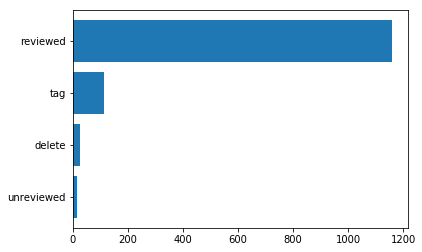

In [48]:
counts = Counter(action_log).most_common()

pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()

Almost 1,200 actions in a single day—integrating JADE with PageTriage's "Mark as reviewed" feature would be productive.  [T198086](https://phabricator.wikimedia.org/T198086)

## FlaggedRevs

During the same 24-hour period, enwiki had 787 FlaggedRevs review actions although FR is only activated on a limited number of pages, and dewiki had 16,209 actions.  It's worth digging into the nature of these actions to see if they're relevant to JADE.

    mysql dewiki -e "select * from logging where log_type='review' and log_timestamp between '20180620000000' and '20180621000000'" > flaggedrevs_dewiki.tsv

In [59]:
with open("flaggedrevs_dewiki.tsv", "r") as f:
    logs = csv.DictReader(f, dialect='excel-tab')

    unique_users = set()
    action_log = []
    
    for line in logs:
        unique_users.add(line["log_user"])
        # "Automatic" reviews should be ignored for our purposes,
        # since they are algorithmically generated.
        if not re.search(r"-.?a$", line["log_action"]):
            action_log.append(line["log_action"])

len(unique_users)

1690

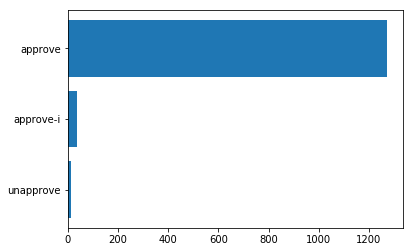

In [60]:
counts = Counter(action_log).most_common()

pos = np.arange(len(counts))
counts.reverse()
plt.barh(
    pos,
    [c[1] for c in counts],
    tick_label=[c[0] for c in counts],
)
plt.show()

Good stuff that we should integrate!  [T198090](https://phabricator.wikimedia.org/T198090)